# Motivation
  To Build an path estimation algorithm only using Acceleration and magnetic field data from Inertial measurement units(IMU) sensor. 

# Sensor Data
- Time stamp
- Acceleration in x,y,z at 23Hz
- Yaw(Heading) calculated from magnetometer values at 23Hz
- Latitude and Longitude from GPS sensor at 1Hz

# Data preprocessing
- Removing NaN

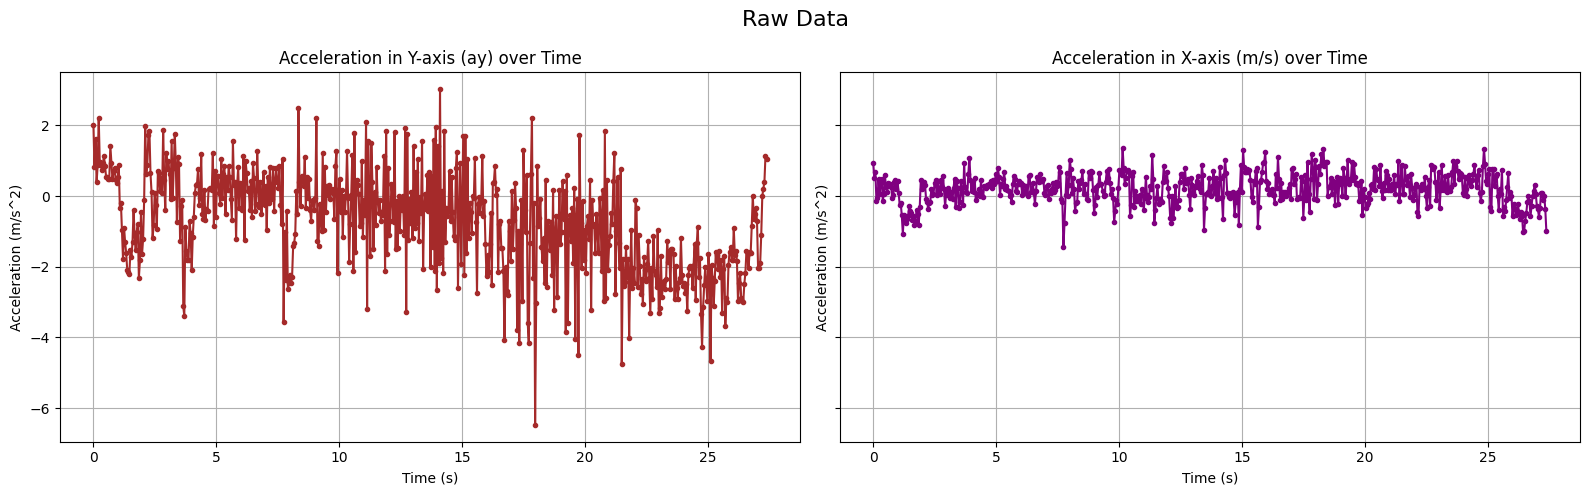

In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

df = pd.read_csv('data1.csv')
# print(df.to_string())

df = df.dropna()
# print(df.to_string())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
fig.suptitle('Raw Data', fontsize=16)
ax1.plot(df['time'], df['ay'], marker='o', linestyle='-', color='brown', markersize=3)
ax1.set_title('Acceleration in Y-axis (ay) over Time') 
ax1.set_xlabel('Time (s)') 
ax1.set_ylabel('Acceleration (m/s^2)') 
ax1.grid(True)

ax2.plot(df['time'], df['ax'], marker='o', linestyle='-', color='purple', markersize=3) 
ax2.set_title('Acceleration in X-axis (m/s) over Time') 
ax2.set_xlabel('Time (s)') 
ax2.set_ylabel('Acceleration (m/s^2)') 
ax2.grid(True)

plt.tight_layout() 
plt.show()


# DC Bias Removal(Sensor Calibration)
 Usually sensors will have a zero error which is known as offset.Offset is calculated and sensor is calibrated

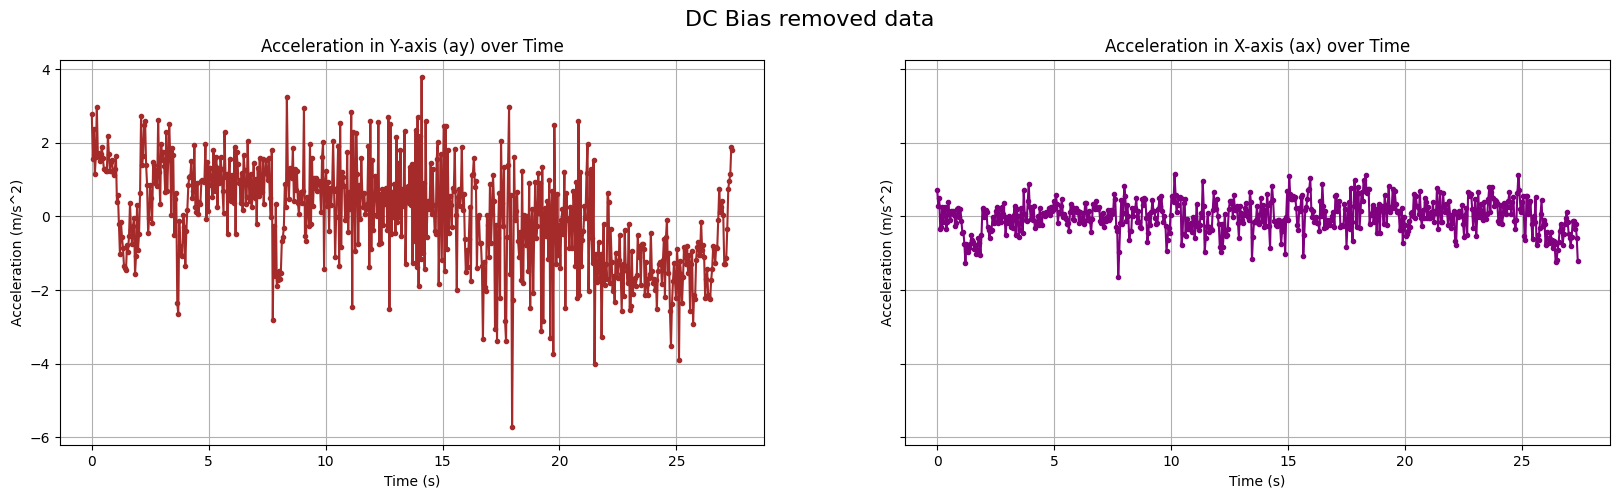

In [275]:
df['ay_bias'] = df['ay'].copy()  # Make a copy of ay
df['ax_bias'] = df['ax'].copy()  # Make a copy of ax

ay_mean = df['ay_bias'].mean()
ax_mean = df['ax_bias'].mean()

for i in range (0,len(df)):
    df.loc[i, 'ay_bias'] = df.loc[i, 'ay_bias'] - ay_mean
    df.loc[i, 'ax_bias'] = df.loc[i, 'ax_bias'] - ax_mean

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
fig.suptitle('DC Bias removed data', fontsize=16)
ax1.plot(df['time'], df['ay_bias'], marker='o', linestyle='-', color='brown', markersize=3)
ax1.set_title('Acceleration in Y-axis (ay) over Time') 
ax1.set_xlabel('Time (s)') 
ax1.set_ylabel('Acceleration (m/s^2)') 
ax1.grid(True)

ax2.plot(df['time'], df['ax_bias'], marker='o', linestyle='-', color='purple', markersize=3) 
ax2.set_title('Acceleration in X-axis (ax) over Time') 
ax2.set_xlabel('Time (s)') 
ax2.set_ylabel('Acceleration (m/s^2)') 
ax2.grid(True)



# Exponential Moving Average Filter
An Exponential Moving Average (EMA) is a type of weighted moving average used to
smooth data and reduce noice amplitude by giving more weight to older observations
and less weight to recent ones. Smoothing factor(α) determines the weight given to the
most recent data point.(α) ranges between 0 and 1. A higher (α) gives more weight to
older observations, making the EMA react slowly to changes.
- EMA = Previous value ∗ (α) + Recent value ∗ (1 − α)

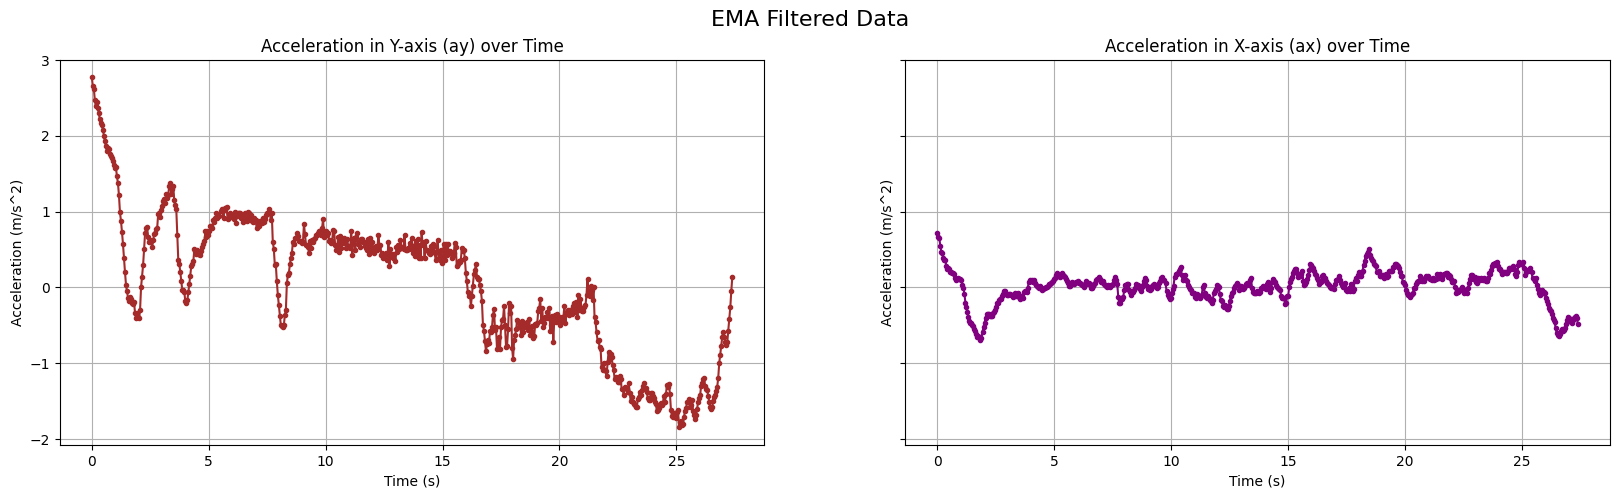

In [276]:
df['ay_ema'] = df['ay_bias'].copy()  # Make a copy of dc bias removed ay
df['ax_ema'] = df['ax_bias'].copy()  # Make a copy of dc bias removed ax

# Apply EMA filter
for i in range(1, len(df)):
    df.loc[i, 'ay_ema'] = df.loc[i - 1, 'ay_ema'] * 0.90 + df.loc[i, 'ay_bias'] * 0.1
    df.loc[i, 'ax_ema'] = df.loc[i - 1, 'ax_ema'] * 0.90 + df.loc[i, 'ax_bias'] * 0.1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
fig.suptitle('EMA Filtered Data', fontsize=16)
ax1.plot(df['time'], df['ay_ema'], marker='o', linestyle='-', color='brown', markersize=3)
ax1.set_title('Acceleration in Y-axis (ay) over Time') 
ax1.set_xlabel('Time (s)') 
ax1.set_ylabel('Acceleration (m/s^2)') 
ax1.grid(True)

ax2.plot(df['time'], df['ax_ema'], marker='o', linestyle='-', color='purple', markersize=3) 
ax2.set_title('Acceleration in X-axis (ax) over Time') 
ax2.set_xlabel('Time (s)') 
ax2.set_ylabel('Acceleration (m/s^2)') 
ax2.grid(True)

# Velocity Estimation
 Acceleration values are integrated to get velocity
 

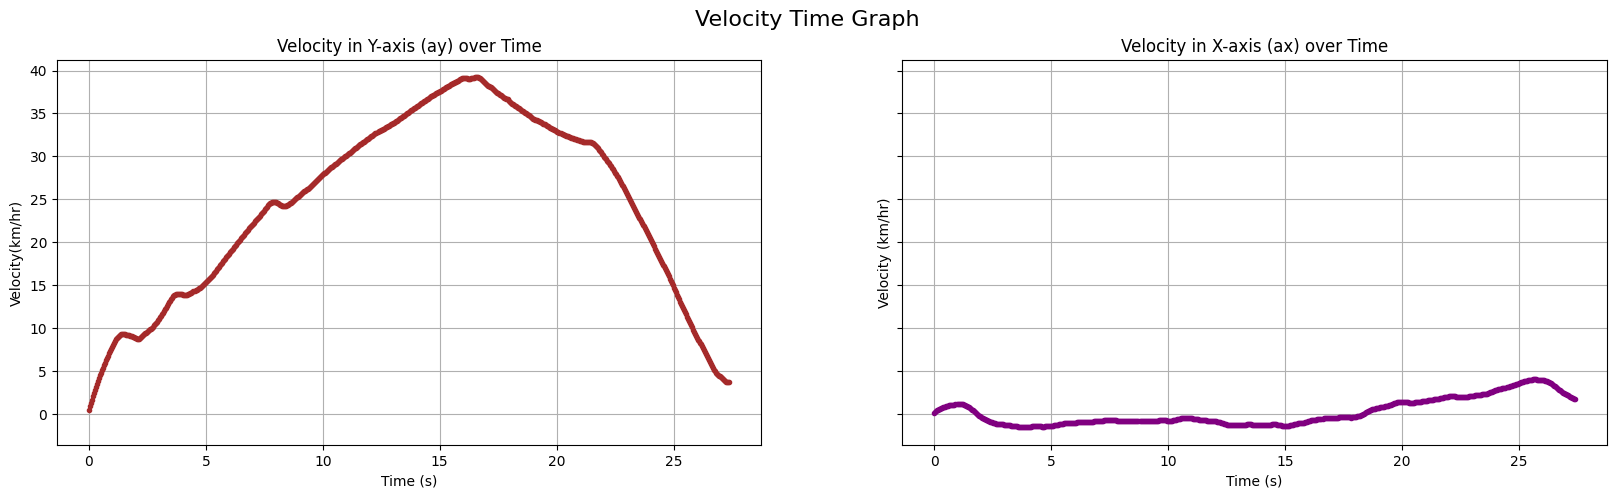

In [277]:
df['vy'] = df['ay_ema'].copy()  # Copy ay for Velocity estimation
df['vx'] = df['ax_ema'].copy()  # Copy ax for Velocity estimation

for i in range(1,len(df)):
    df.loc[i, 'vy'] = (df.loc[i - 1, 'vy'] + df.loc[i, 'ay_ema'] ) 
    df.loc[i, 'vx'] = (df.loc[i - 1, 'vx'] + df.loc[i, 'ax_ema'] ) 

df['vy'] = df['vy'] /23  # Divide by 23 since 23 samples/s
df['vx'] = df['vx'] /23 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
fig.suptitle('Velocity Time Graph', fontsize=16)
ax1.plot(df['time'], df['vy']*18/5, marker='o', linestyle='-', color='brown', markersize=3)
ax1.set_title('Velocity in Y-axis (ay) over Time') 
ax1.set_xlabel('Time (s)') 
ax1.set_ylabel('Velocity(km/hr)') 
ax1.grid(True)

ax2.plot(df['time'], df['vx']*18/5, marker='o', linestyle='-', color='purple', markersize=3) 
ax2.set_title('Velocity in X-axis (ax) over Time') 
ax2.set_xlabel('Time (s)') 
ax2.set_ylabel('Velocity (km/hr)') 
ax2.grid(True)


# Distance Estimation
Velocity is further integrated to get distance

Distance travelled in X-axis: 1.4890245525802952
Distance travelled in Y-axis: 186.39463778864015
Net Distance: 186.4005852739646


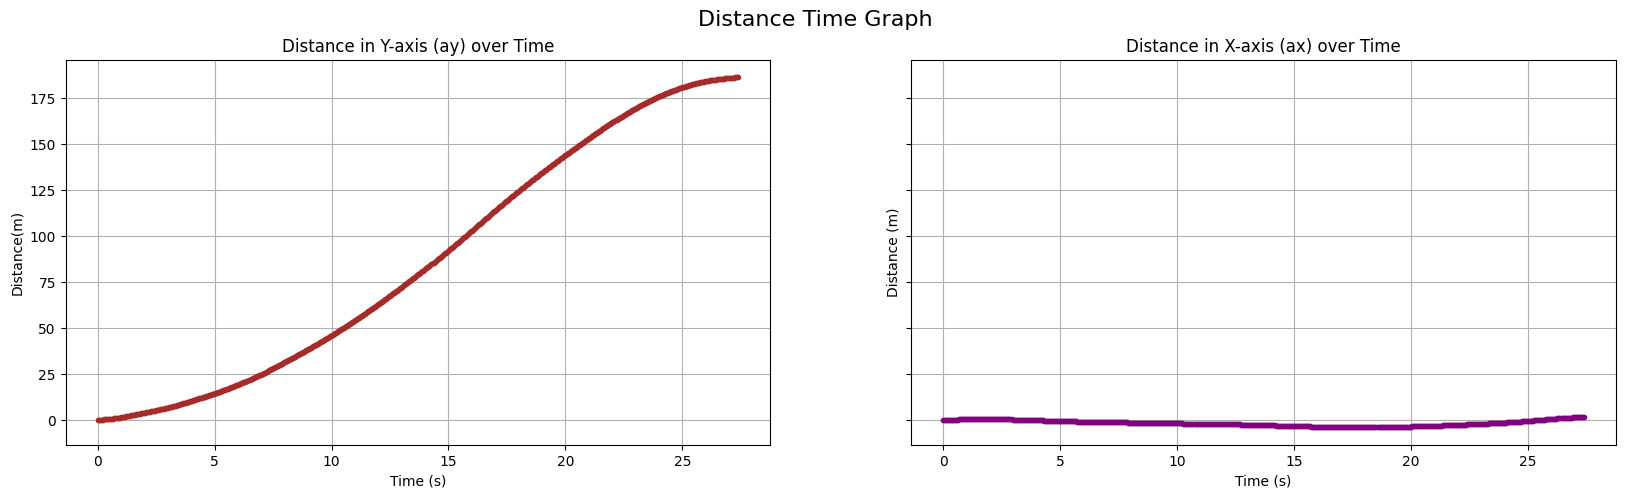

In [278]:
df['sy'] = df['vy'].copy()  # Copy ay for Velocity estimation
df['sx'] = df['vx'].copy()  # Copy ax for Velocity estimation

for i in range(1,len(df)):
    df.loc[i, 'sy'] = (df.loc[i - 1, 'sy'] + df.loc[i, 'vy'] )
    df.loc[i, 'sx'] = (df.loc[i - 1, 'sx'] + df.loc[i, 'vx']) 

df['sy'] = df['sy'] /23  # Divide by 23 since 23 samples/s
df['sx'] = df['sx'] /23 

dx = df['sx'].iloc[-1]
dy = df['sy'].iloc[-1]
distance = math.sqrt(dx**2 + dy**2)
print('Distance travelled in X-axis:',dx)
print('Distance travelled in Y-axis:',dy)
print('Net Distance:',distance)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
fig.suptitle('Distance Time Graph', fontsize=16)
ax1.plot(df['time'], df['sy'], marker='o', linestyle='-', color='brown', markersize=3)
ax1.set_title('Distance in Y-axis (ay) over Time') 
ax1.set_xlabel('Time (s)') 
ax1.set_ylabel('Distance(m)') 
ax1.grid(True)

ax2.plot(df['time'], df['sx'], marker='o', linestyle='-', color='purple', markersize=3) 
ax2.set_title('Distance in X-axis (ax) over Time') 
ax2.set_xlabel('Time (s)') 
ax2.set_ylabel('Distance (m)') 
ax2.grid(True)
# print(df.to_string())

# Converting Distances to Global frame of reference(NWU)
- The distance obtained is in sensor frame of reference. 
- This distance is converted to global frame of reference.
-  X-axis is taken as North, Y-axis as West and Z-axis as Up.
- Thus the distances travelled along North and West direction are obtained. Formula for
the conversion is given below
- DN = Dx cos(θ) − Dy sin(θ)
- DW = −Dx sin(θ) − Dy cos(θ)

Distance travelled in North: 183.3574141592405
Distance travelled in West: 33.5445504264598
Net Distance: 186.40058527396462


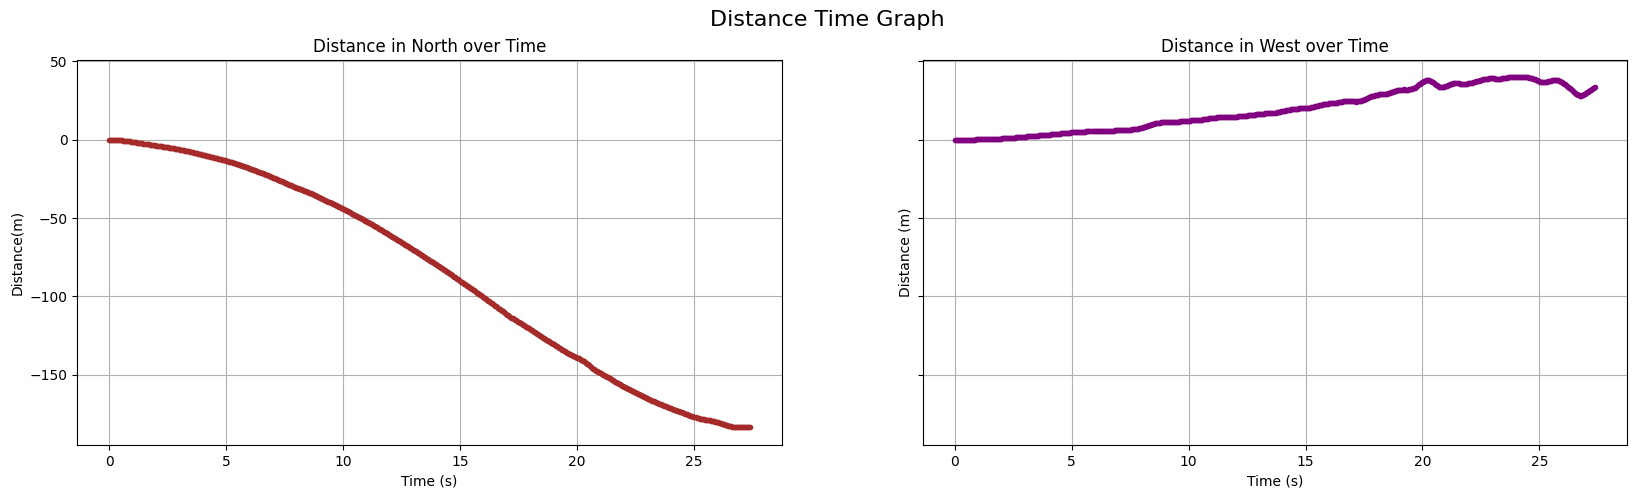

In [279]:
df['Dn'] = df['sx'] * np.cos(np.radians(df['yaw'])) - df['sy'] * np.sin(np.radians(df['yaw']))
df['Dw'] = -df['sx'] * np.sin(np.radians(df['yaw'])) - df['sy'] * np.cos(np.radians(df['yaw']))

df['distance'] = np.sqrt(df['Dn']**2 + df['Dw']**2)
print('Distance travelled in North:',-df['Dn'].iloc[-1])
print('Distance travelled in West:',df['Dw'].iloc[-1])
print('Net Distance:',df['distance'].iloc[-1])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=True)

fig.suptitle('Distance Time Graph', fontsize=16)
ax1.plot(df['time'], df['Dn'], marker='o', linestyle='-', color='brown', markersize=3)
ax1.set_title('Distance in North over Time') 
ax1.set_xlabel('Time (s)') 
ax1.set_ylabel('Distance(m)') 
ax1.grid(True)

ax2.plot(df['time'], df['Dw'], marker='o', linestyle='-', color='purple', markersize=3) 
ax2.set_title('Distance in West over Time') 
ax2.set_xlabel('Time (s)') 
ax2.set_ylabel('Distance (m)') 
ax2.grid(True)
# print(df.to_string())


# Latitude and Longitude Calculation
Using heading data from the AHRS algorithm and resultant distance calculated above,
the final latitude and the longitude can be obtained from the initial latitude and
longitude as shown below:
- The degree to radian conversion can be done as given below:
- Angle in Radians = Angle in Degrees *π/180

- Central angle between initial position and final position(in rad)
- δ = Resultant distance(d)/Radius of earth(6371000m)

Let,
Lat1 = Initial Latitude,
Long1 = Initial Longitude,
Lat2 = Final Latitude,
Long2 = Final Longitude,

- Lat2 = arcsin(sin(Lat1) ∗ cos(δ) + cos(Lat1) ∗ sin(δ) ∗ cos(heading))
- Long2 = Long1 + atan2{sin(heading) ∗ sin(δ) ∗ cos(Lat1),cos(δ) − sin(Lat1) ∗ sin(lat2)}

Obtained Latitude and longitude is then converted back to degrees using the formula
Angle in degrees = Angle in Radians *180/π


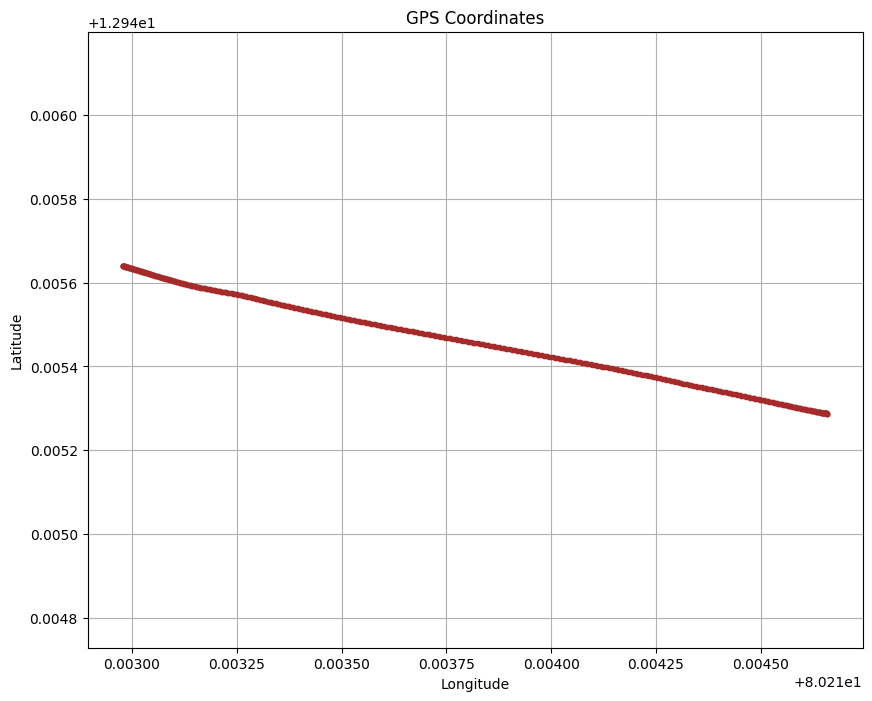

       time      ax       ay       az       yaw    gps_lat    gps_lon   ay_bias   ax_bias    ay_ema    ax_ema         vy        vx          sy        sx          Dn         Dw    distance   pred_lat   pred_lon
0     0.000  0.9208  2.01992   9.3312  106.9097  12.945640  80.212978  2.770411  0.710587  2.770411  0.710587   0.120453  0.030895    0.005237  0.001343   -0.005401   0.000238    0.005407  12.945640  80.212978
1     0.043  0.5018  0.81512   9.5670  106.9644   0.000000   0.000000  1.565611  0.291587  2.649931  0.668687   0.235667  0.059968    0.015483  0.003951   -0.015962   0.000739    0.015980  12.945640  80.212978
2     0.086  0.6934  1.61096   9.8567  107.0134   0.000000   0.000000  2.361451  0.483187  2.621083  0.650137   0.349627  0.088235    0.030685  0.007787   -0.031620   0.001532    0.031657  12.945640  80.212978
3     0.129 -0.1290  0.38512  10.5558  107.0761   0.000000   0.000000  1.135611 -0.339213  2.472536  0.551202   0.457129  0.112201    0.050560  0.012665   -0.05

In [280]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# linear
initial_lat = 12.945640
initial_lon = 80.212978

# #circular
# initial_lat = 12.945866
# initial_lon = 80.212048

# Set initial coordinates
df.loc[0, 'pred_lat'] = initial_lat
df.loc[0, 'pred_lon'] = initial_lon

# Function to convert distance and heading to new coordinates
def convert_distance_to_coordinates(lat1, lon1, distance, heading):
    # Convert degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    heading_rad = np.radians(heading)

    # Convert distance to radians
    delta = distance / 6371000  # Earth's radius in meters

    # Calculate final latitude and longitude
    lat2_rad = np.arcsin(np.sin(lat1_rad) * np.cos(delta) + np.cos(lat1_rad) * np.sin(delta) * np.cos(heading_rad))
    lon2_rad = lon1_rad + np.arctan2(np.sin(heading_rad) * np.sin(delta) * np.cos(lat1_rad),
                                      np.cos(delta) - np.sin(lat1_rad) * np.sin(lat2_rad))

    # Convert radians back to degrees
    lat2 = np.degrees(lat2_rad)
    lon2 = np.degrees(lon2_rad)

    return lat2, lon2

# Loop to calculate and update coordinates
for i in range(1, len(df)):
    lat, lon = convert_distance_to_coordinates(df.loc[i - 1, 'pred_lat'], df.loc[i - 1, 'pred_lon'], df.loc[i, 'distance']-df.loc[i-1, 'distance'], df.loc[i, 'yaw'])
    df.loc[i, 'pred_lat'] = lat
    df.loc[i, 'pred_lon'] = lon

# Plotting the path
plt.figure(figsize=(10, 8))  
plt.plot(df['pred_lon'] , df['pred_lat'], marker='o', linestyle='-', color='brown', markersize=3)
plt.title('GPS Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.axis('equal')  # Set equal scale for x and y axes
plt.show()


print(df.to_string())

# Actual path travelled
 - round path
![Image Alt Text](round_path.png)
 - straight path
![Image Alt Text](straight_path.png)

In [281]:

# new_df = df[['time', 'ax', 'ay', 'az', 'yaw', 'gps_lat', 'gps_lon', 'distance', 'pred_lat', 'pred_lon']].copy()

# # Convert the new dataframe to a CSV file
# # print(new_df.to_string())   
# new_df.to_csv('new_round1.csv', index=False)


# Verifying the algorithm
using the latlong obtained from gps and predicted lat long distance is calculated and MAE and RMSE is calculated

Mean Absolute Error (MAE): 3.27 meters
Root Mean Square Error (RMSE): 4.00 meters


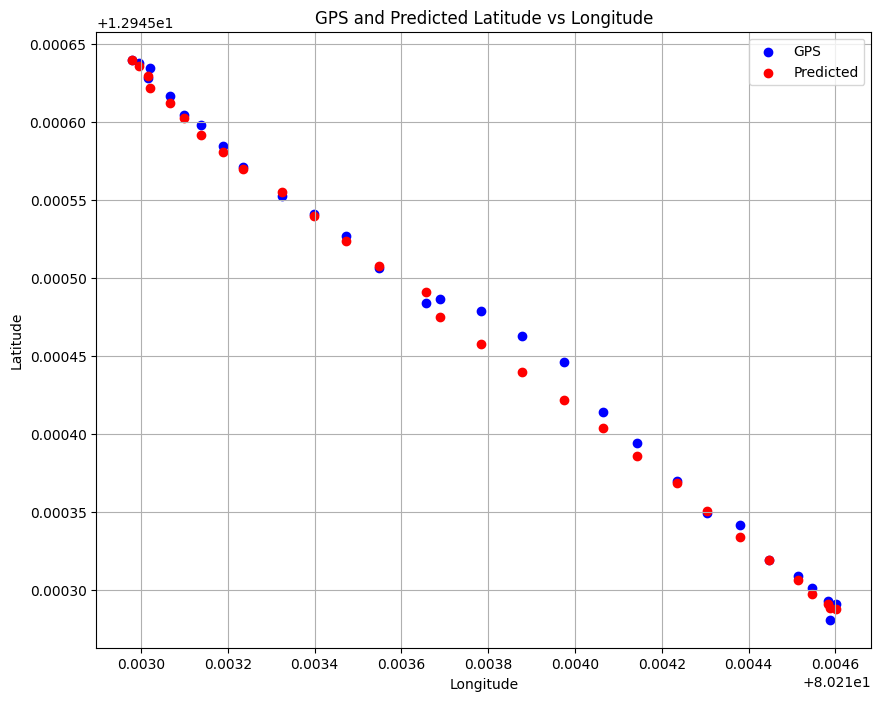

In [287]:
import numpy as np
from math import radians, sin, cos, sqrt, atan2

# Filter the dataframe to exclude rows where gps_lat and gps_lon are zero
filtered_df = df[(df['gps_lat'] != 0) & (df['gps_lon'] != 0)]

def haversine(lat1, lon1, lat2, lon2):
    # Convert coordinates from degrees to radians
    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat2_rad = radians(lat2)
    lon2_rad = radians(lon2)

    # Haversine formula
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = sin(dlat / 2) ** 2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = 6371000 * c  # Earth's radius in meters
    return distance


# Calculate distances between corresponding GPS and predicted points with debugging info
distances = []
for i, (gps_lat, gps_lon, pred_lat, pred_lon) in enumerate(zip(
        filtered_df['gps_lat'], filtered_df['gps_lon'],
        filtered_df['pred_lat'], filtered_df['pred_lon'])):
    
    # Calculate the distance and add it to the list
    distance = haversine(gps_lat, gps_lon, pred_lat, pred_lon)
    distances.append(distance)


 
# Calculate MAE and RMSE
mae = np.mean(np.abs(distances))
rmse = np.sqrt(np.mean(np.array(distances)**2))

print(f"Mean Absolute Error (MAE): {mae:.2f} meters")
print(f"Root Mean Square Error (RMSE): {rmse:.2f} meters")

# Filter the dataframe to exclude rows where gps_lat and gps_lon are zero
filtered_df = df[(df['gps_lat'] != 0) & (df['gps_lon'] != 0)]

# Plotting gps_lat vs gps_lon and pred_lat vs gps_lon in the same figure
plt.figure(figsize=(10, 8))
plt.scatter(filtered_df['gps_lon'], filtered_df['gps_lat'], color='blue', label='GPS')
plt.scatter(filtered_df['gps_lon'], filtered_df['pred_lat'], color='red', label='Predicted')
plt.title('GPS and Predicted Latitude vs Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
# plt.xlim(right=80.2125)
plt.grid(True)
plt.show()



# K-Means Clustering
k-Means clustering is done based on velocity to differentate the speed

/home/karthick/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/karthick/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


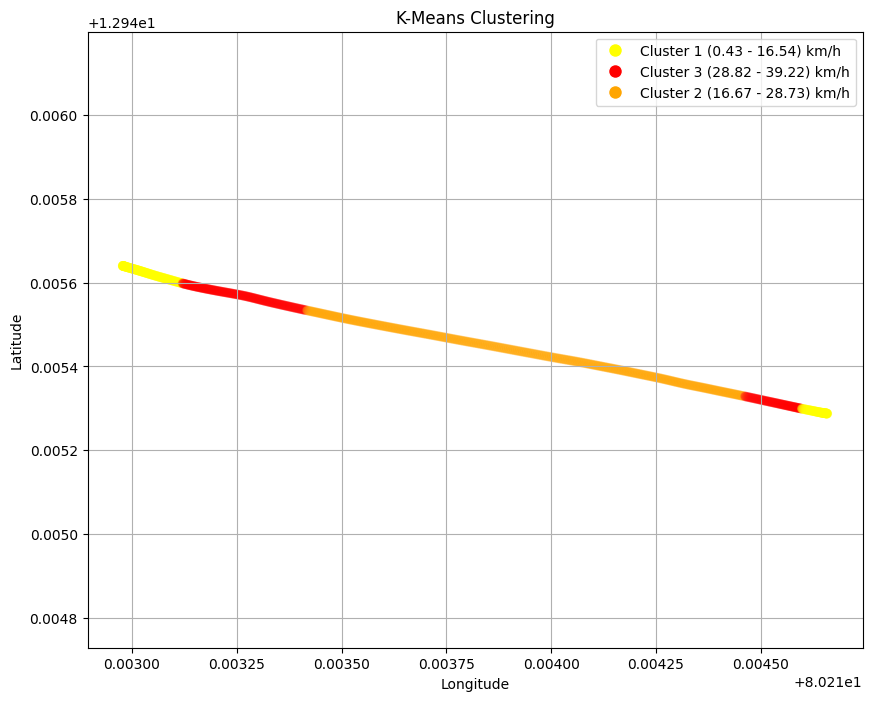

In [283]:
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Convert vy to km/h
df['vy_kmph'] = df['vy'] * 3.6

# Perform k-means clustering using the velocity in km/h
kmeans = KMeans(n_clusters=3, init=np.array([[0], [(df['vy_kmph']).mean()], [max(df['vy_kmph'])]]), random_state=0)
df['cluster'] = kmeans.fit_predict(df[['vy_kmph']])

# Define color map and create legend labels with min and max speeds for each cluster
colors = ['yellow', 'red', 'orange']
speed_range = []

# Calculate min and max for each cluster and update legend labels
for i in range(3):
    cluster_vy_kmph = df[df['cluster'] == i]['vy_kmph']
    min_vy_kmph = max(0, cluster_vy_kmph.min())  # Set negative min values to zero
    max_vy_kmph = cluster_vy_kmph.max()
    speed_range.append(f"Cluster {i + 1} ({min_vy_kmph:.2f} - {max_vy_kmph:.2f}) km/h")

speed_range[1], speed_range[2] = speed_range[2], speed_range[1]
# Plot latitude-longitude plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['pred_lon'],  df['pred_lat'], c=df['cluster'], cmap=ListedColormap(colors), alpha=0.31)

# Create legend with min and max speeds for each cluster
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label=speed_range[i], markerfacecolor=colors[i], markersize=10) 
    for i in range(len(speed_range))
]
plt.legend(handles=legend_elements, loc='upper right')

# Plot settings
plt.title('K-Means Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.axis('equal')  # Set equal scale for x and y axes
plt.show()


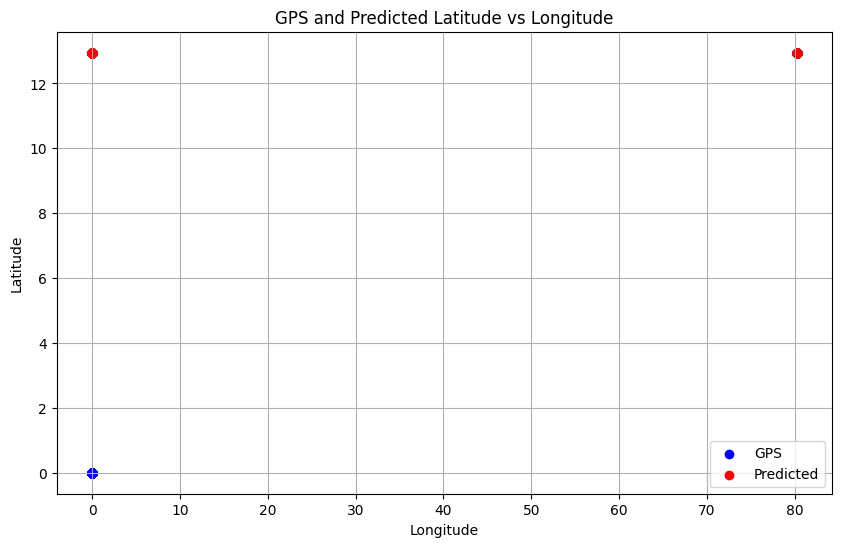